# Save a movie showing a few instances of giving up

## Todo: make it a normal aspect ratio, add timer to indicate duration elapsed

In [13]:
%matplotlib inline
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from fish.image.zds import ZDS
from fish.ephys.ephys import load
from fish.util.distributed import get_cluster
import dask.array as da
from dask.distributed import Client
from dask.delayed import delayed
from functools import partial
from dask import threaded
from h5py import File
import flika as flk
import time
flk.start_flika()

from skimage.transform import downscale_local_mean
from scipy.ndimage.filters import median_filter

from matplotlib import cm
from skimage.exposure import rescale_intensity as rescale
from scipy.ndimage.filters import gaussian_filter
from moviepy.editor import ImageSequenceClip, VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [14]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def montage(vol, rgb=False):
    if rgb:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0] * vol.shape[1], vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])
    else:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])

In [15]:
base_dir = '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
ephys = File(base_dir + 'ephys/data.mat')['data']
gain_signal = np.squeeze(File(base_dir + 'ephys/rawdata.mat')['rawdata/stimGain'][:])
swims = np.squeeze(ephys['fltCh1'][:] + ephys['fltCh2'][:])
cam = np.squeeze(ephys['frame'][:]) - 1
shifts = -np.load(base_dir + 'regparams_affine.npy')[:,:-1,-1]
shifts = median_filter(shifts, size=(300,1))
dset = ZDS(base_dir + 'raw/')
chunks=dset.shape[1:]
planes = np.linspace(5, dset.shape[1]-3, 5).astype('int')
zstep = int(np.diff(planes[:2]))
print(planes)

[ 5 10 15 20 26]


In [16]:
%%time
roi = (slice(100, 600), slice(planes[0], planes[-1], zstep), slice(None), slice(None))
data = da.stack([da.from_array(File(f, 'r')['default'], chunks=chunks) for f in dset.files])[roi]
data_tx = data.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data_tx.map_blocks(medfilt)

ds_xy = 4
downscale = partial(downscale_local_mean, factors=(1,1,ds_xy,ds_xy))
data_ds = data_filt.map_blocks(downscale, chunks=(1, data.shape[1], data.shape[2]//ds_xy, data.shape[3]//ds_xy))
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 32,32))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

ref_range = slice(0, 10)
ref = data_ds[ref_range].mean(0).compute(get=threaded.get)

CPU times: user 2min 47s, sys: 24.1 s, total: 3min 11s
Wall time: 5min 25s


In [23]:
%%bash
bjobs

JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
39627047   bennett RUN   interactiv c11u25      10*h06u26   /bin/bash  May 17 03:31


In [24]:
cluster = get_cluster()
#cluster.adapt()
#client = Client(cluster)
#client

In [ ]:
%%time
#cluster.start_workers(200)
# give some time for the workers to arrive
#time.sleep(20)
result_dff = client.compute(data_dff, sync=True)
#cluster.stop_workers(cluster.workers)
#cluster.close()

In [ ]:
result_dff.shape

In [156]:
out_path = '/groups/ahrens/ahrenslab/davis/tmp/dask_testing/tmp.npy'
np.save(out_path, result_dff)

In [12]:
out_path = '/groups/ahrens/ahrenslab/davis/tmp/dask_testing/tmp.npy'
result_dff = np.load(out_path)
# crop the image to remove dff artifacts induced by motion correction
crop= (slice(None), slice(None), slice(10, -10), slice(10, -10))
cropped=result_dff[crop]

In [17]:
result_dff.shape

(500, 5, 512, 512)

In [159]:
gammas = [.5,1]
bg = (255 * (cm.gray(rescale(gaussian_filter(ref, sigma=(0,1,1))[crop[-3], crop[-2], crop[-1]],in_range=(102, 250), out_range=(0,.5)) ** gammas[0])[:,:,:,:-1])).astype('int')

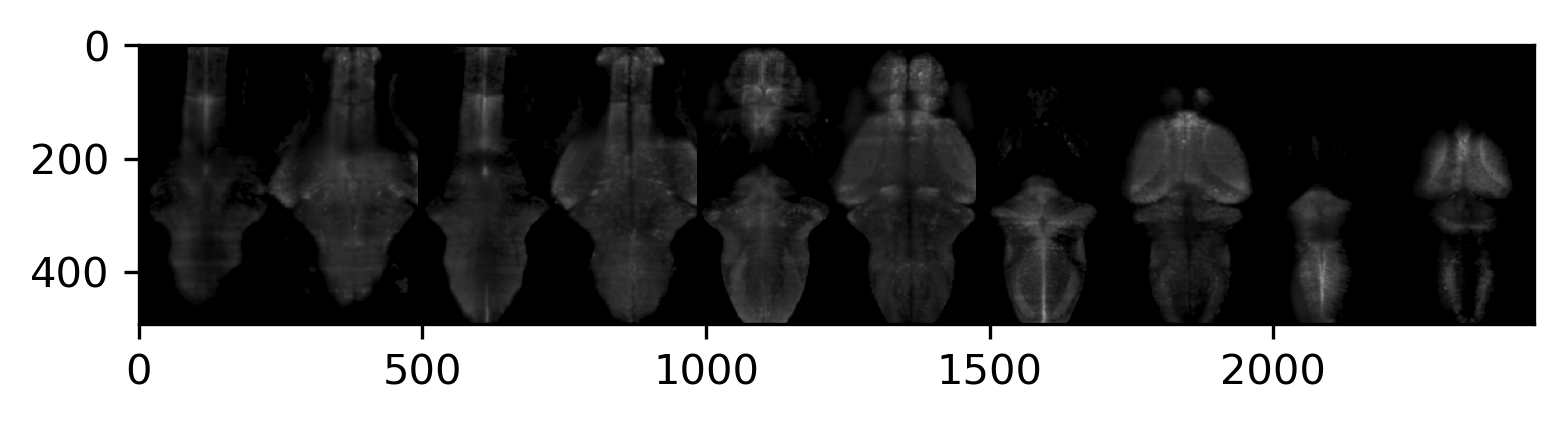

In [160]:
fig, axs = plt.subplots(dpi=300)
plt.imshow(montage(bg, rgb=True).transpose(1,0,2))

In [163]:
# todo: add labels for open vs closed loop

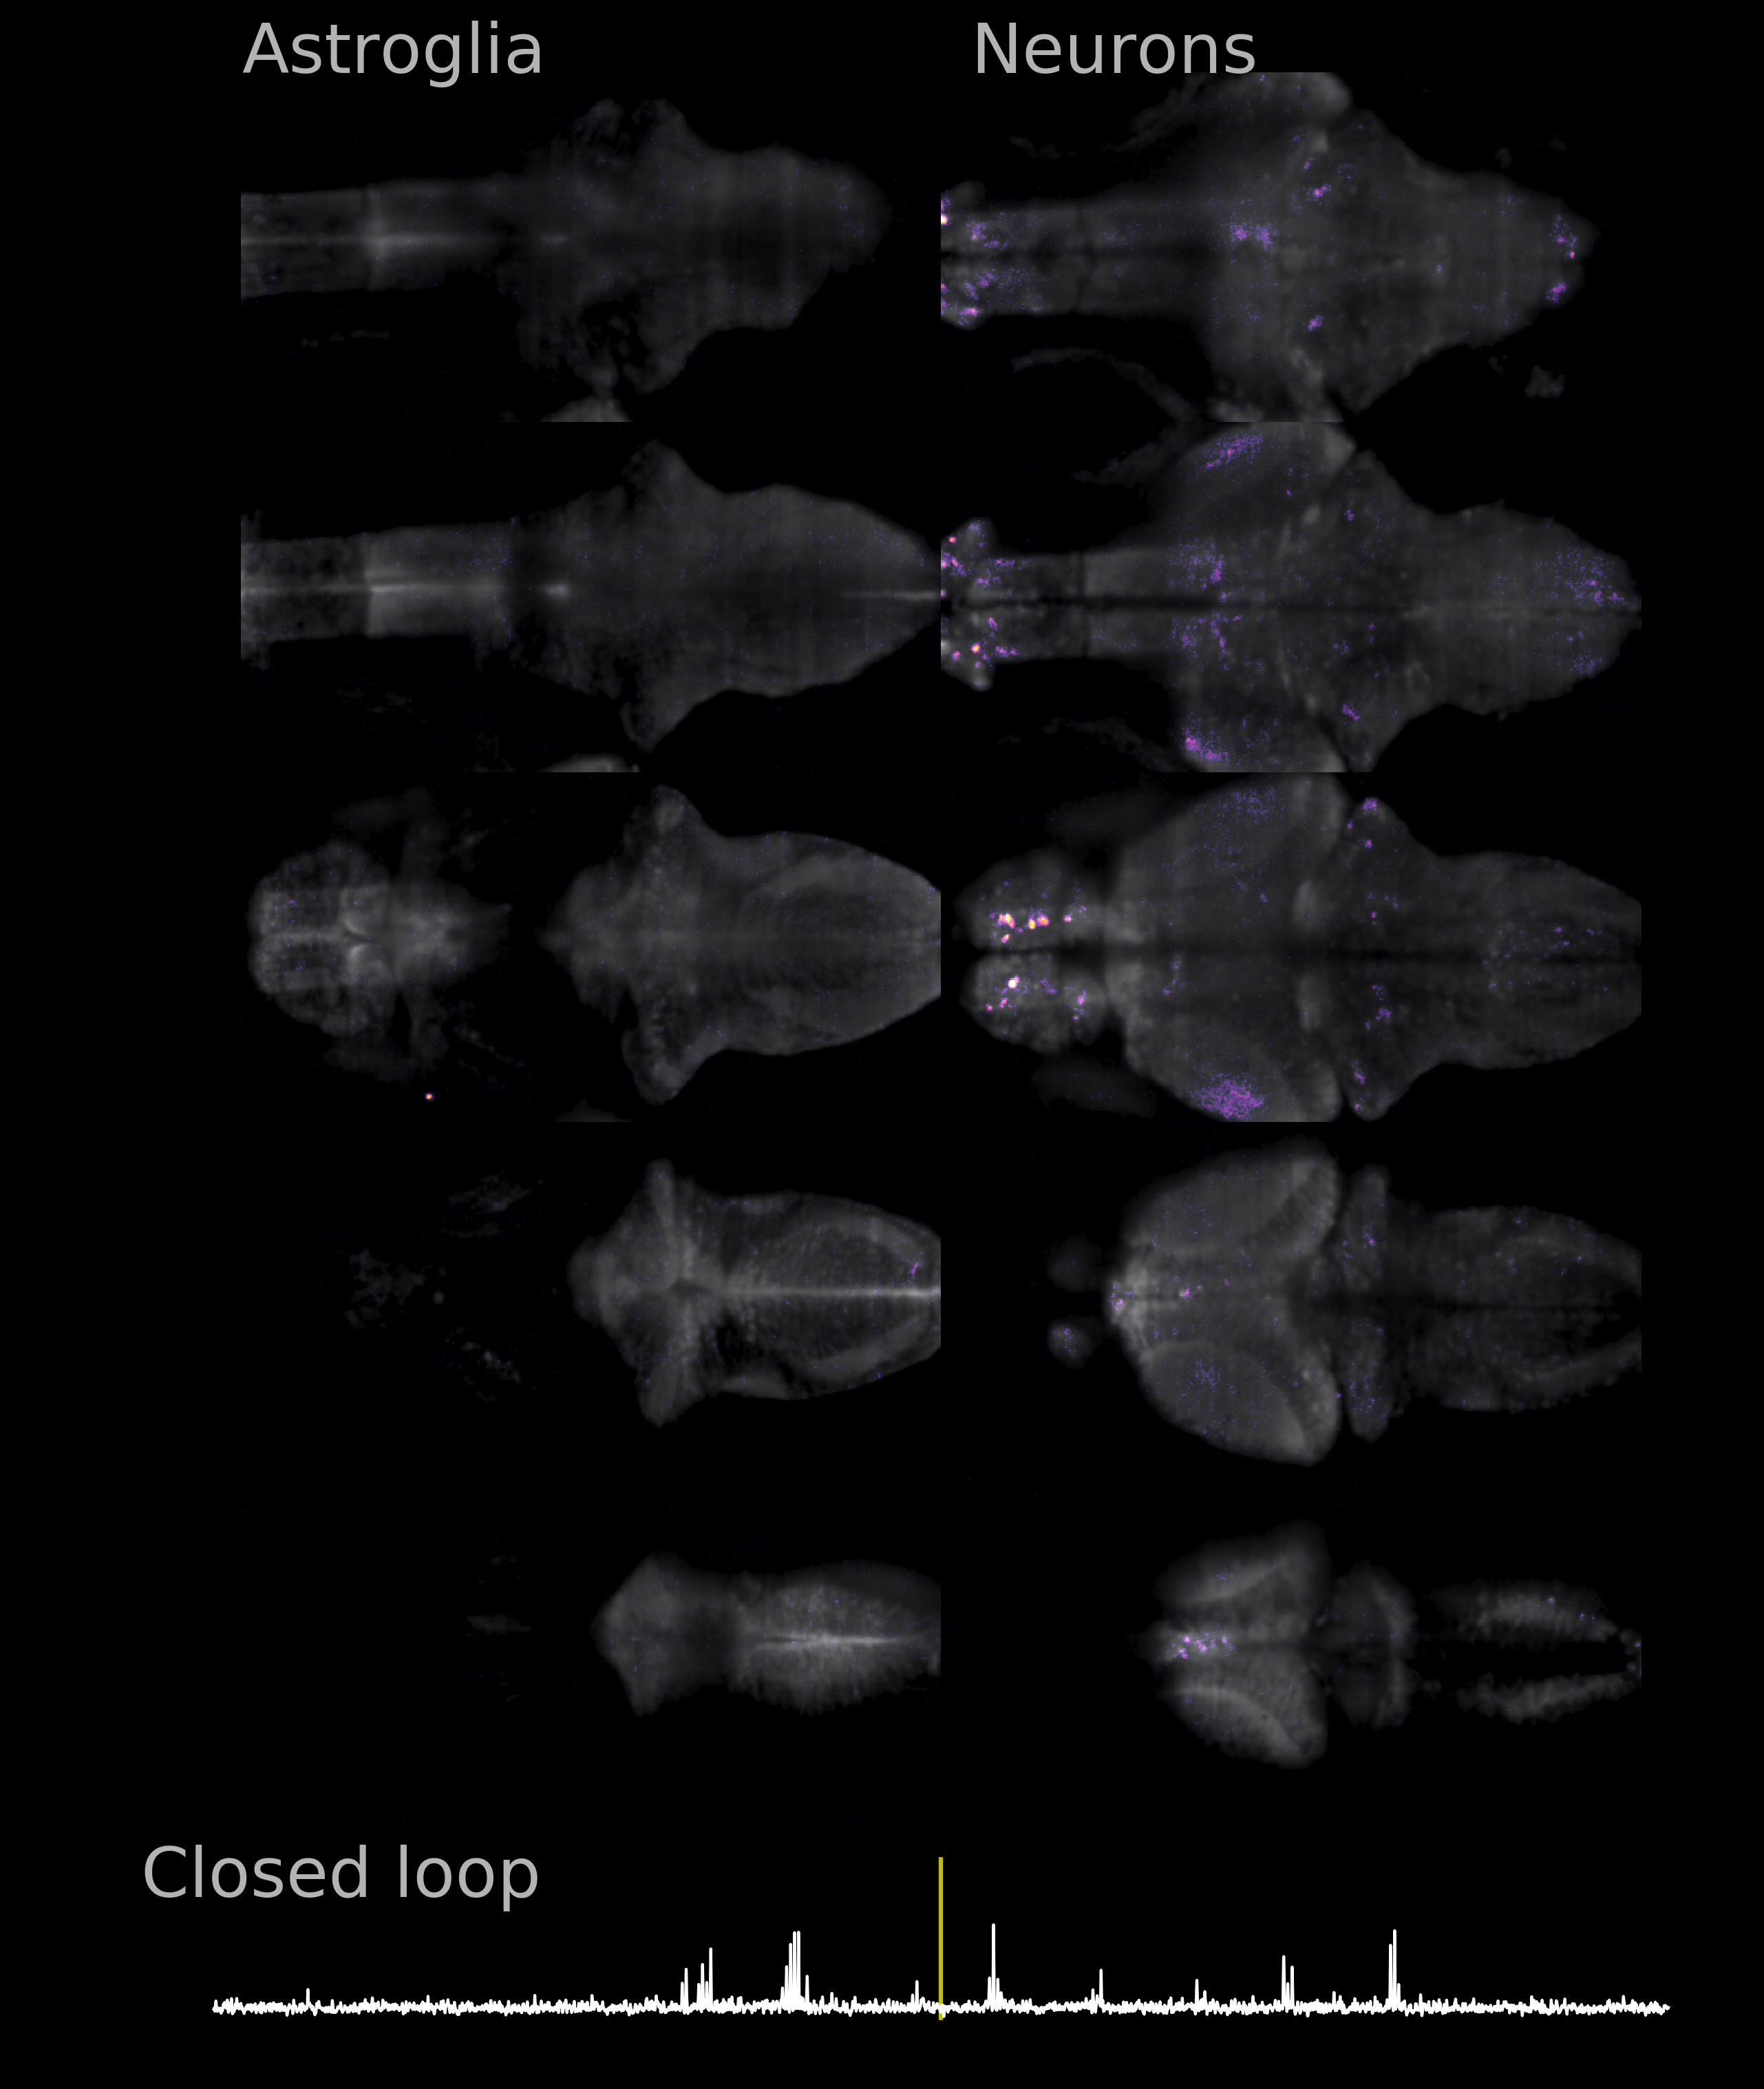

In [20]:
gammas = [.5,1]
bg = (255 * (cm.gray(rescale(gaussian_filter(ref, sigma=(0,1,1))[crop[-3], crop[-2], crop[-1]],in_range=(102, 250), out_range=(0,.5)) ** gammas[0]))).astype('int')
fs_ep = 6000
ep_window = np.arange(-8 * fs_ep, 8 * fs_ep)

def rearrange(im):
    mp = im.shape[1]//2
    return montage(np.concatenate([im[:,:mp], im[:,mp:]], axis=2), rgb=True)

im_ar = rearrange(bg).shape[0] / rearrange(bg).shape[1]
fig = plt.figure(dpi=300, figsize=(10 , 10 * im_ar), facecolor='k')
gsp = gs.GridSpec(10,10)
ax_im = fig.add_subplot(gsp[:-1,:])
ax_ep = fig.add_subplot(gsp[-1:,:])
ax_ep.set_facecolor('k')

duration = 60

def drawf(t_):
    fd = {'fontsize' : 24, 'color' : (.7,.7,.7)}
    gain_text = ('Closed loop', 'Open loop')
    ax_ep.clear()
    ax_im.clear()
    t = int((t_/ duration) * cropped.shape[0])
    composite = bg + rescale(cm.inferno(rescale(cropped[t], in_range=(.05, .6))), out_range='uint8').astype('uint8')
    mont = rearrange(composite)
    ax_im.imshow(mont)    
    ax_im.axis('off')
    ax_im.text(0,0, 'Astroglia', fontdict=fd)
    ax_im.text(512,0, 'Neurons', fontdict=fd)
    t_ep = np.where(cam == t + roi[0].start)[0][0]
    
    gain_ind = (gain_signal[t_ep] == 0.0).astype('int')
    ep_plr = t_ep + ep_window
    ax_ep.axvline(t_ep, color='y')
    ax_ep.plot(ep_plr, swims[ep_plr], color='w', linewidth=1)
    ax_ep.set_ylim(swims.min(), swims.max() / 3)
    ax_ep.text(0, .75, '{0}'.format(gain_text[gain_ind]),transform=ax_ep.transAxes, fontdict=fd)
    return mplfig_to_npimage(fig)

animation = VideoClip(drawf, duration=duration)

In [22]:
codec = 'mpeg4'
start, stop = roi[0].start, roi[0].stop
exp_name = dset.metadata['data_header']
animation.write_videofile('/groups/ahrens/ahrenslab/davis/tmp/{0}_t{1}t{2}.avi'.format(exp_name, start, stop), audio=False, codec=codec, fps=4)

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t100t600.avi
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t100t600.avi


100%|█████████▉| 240/241 [02:12<00:00,  1.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t100t600.avi 

